In [1]:
import os

In [2]:
import cv2 as cv
import numpy as np
import torch
from torchvision import transforms
from tqdm import tqdm
%matplotlib inline
import matplotlib.pyplot as plt

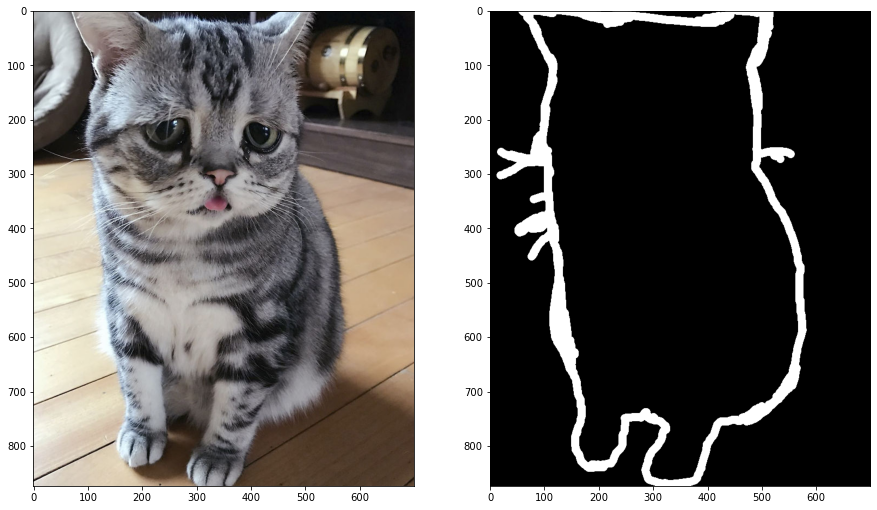

In [3]:
#load image
img = cv.imread("test_images/hinh-anh-meo-buon-ngo-nghinh_020436092.jpg") #BGR image
img = img[...,::-1]
plt.figure(figsize=(15, 15))
pre_trimap = cv.imread("test_images/hinh-anh-meo-buon-ngo-nghinh_020436092_pre_trimap.png", cv.IMREAD_GRAYSCALE)
plt.subplot(1,2,1)
plt.imshow(img)
plt.subplot(1,2,2)
plt.imshow(pre_trimap, cmap='gray')

(874, 700)


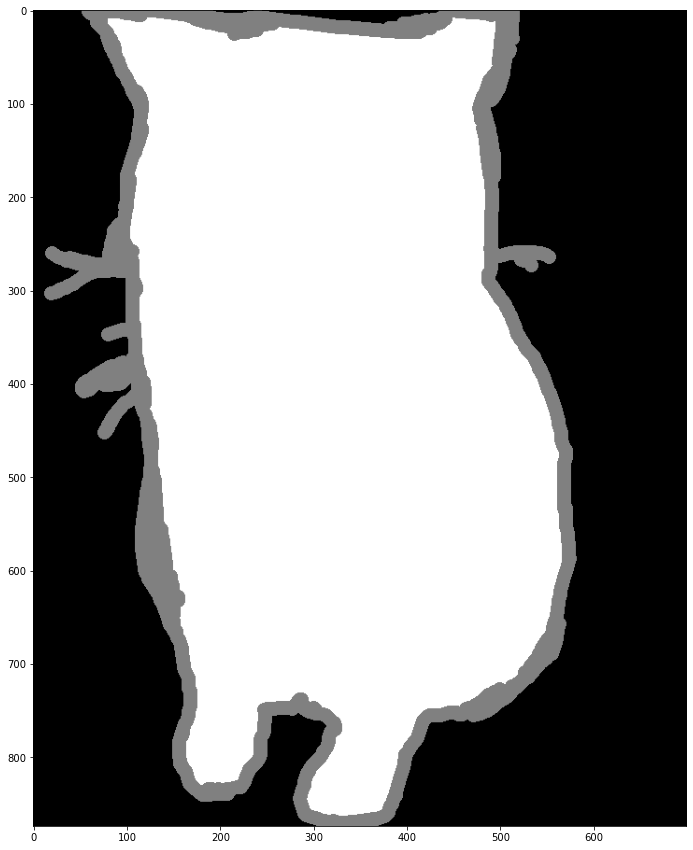

In [4]:
mask = pre_trimap == 128
cnts = cv.findContours(pre_trimap, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if len(cnts) == 2 else cnts[1]
cv.fillPoly(pre_trimap, cnts, 255)
print(pre_trimap.shape)
pre_trimap[mask] = 128
plt.figure(figsize=(15, 15))
plt.imshow(pre_trimap, cmap='gray')
trimap = pre_trimap

In [5]:
#load model
devices = ['cpu', 'cuda']
device = devices[0]
checkpoint="checkpoints_1_1_7/checkpoint_62_0.0495.tar"
if device == 'cpu':
    checkpoint = torch.load(checkpoint, map_location=lambda storage, loc: storage)
else:
    checkpoint = torch.load(checkpoint)
model = checkpoint['model']
model = model.module.to(device)
model.eval()

C:\ProgramData\Anaconda3\envs\dl\lib\site-packages\torch\serialization.py:657: SourceChangeWarning: source code of class 'torch.nn.modules.conv.Conv2d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


DIMModel(
  (down1): segnetDown2(
    (conv1): conv2DBatchNormRelu(
      (cbr_unit): Sequential(
        (0): Conv2d(4, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
    )
    (conv2): conv2DBatchNormRelu(
      (cbr_unit): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
    )
    (maxpool_with_argmax): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (down2): segnetDown2(
    (conv1): conv2DBatchNormRelu(
      (cbr_unit): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
   

In [8]:
data_transforms = {
    'train': transforms.Compose([
        transforms.ColorJitter(brightness=0.125, contrast=0.125, saturation=0.125),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]),
    'valid': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}
transformer = data_transforms['valid']

In [9]:
h, w = img.shape[:2]
x = torch.zeros((1, 4, h, w), dtype=torch.float)
# image = img[..., ::-1]  # RGB
image = img
image = transforms.ToPILImage()(image)
image = transformer(image)
x[0:, 0:3, :, :] = image
x[0:, 3, :, :] = torch.from_numpy(trimap.copy() / 255.)
x = x.type(torch.FloatTensor).to(device)

In [10]:
with torch.no_grad():
    pred = model(x)

In [11]:
pred_numpy = pred.cpu().numpy()
pred_numpy_reshape = pred_numpy.reshape((h, w))

pred_numpy_reshape[trimap == 0] = 0.0
pred_numpy_reshape[trimap == 255] = 1.0

out = (pred_numpy_reshape.copy() * 255).astype(np.uint8)

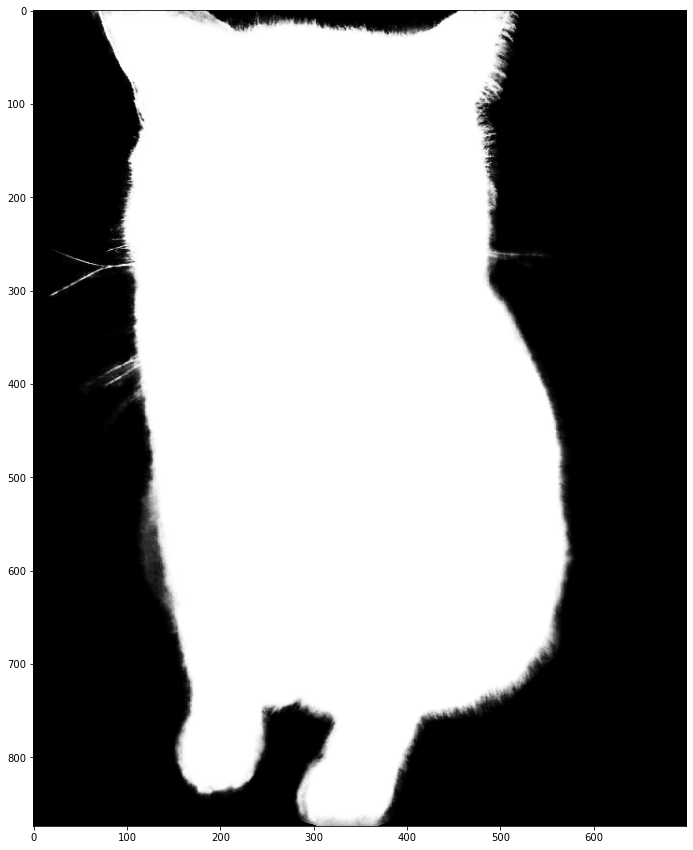

In [12]:
plt.figure(figsize=(15, 15))
plt.imshow(out, cmap='gray')

In [13]:
image = img.copy()
image = np.transpose(image, (2,0,1))
rgb_out = image * pred_numpy
rgb_out = np.transpose(rgb_out,(1,2,0))
rgb_out = rgb_out.astype(np.uint8)
out_expand = np.expand_dims(out, 2)
transparent_out = np.concatenate([rgb_out, out_expand], axis=2)

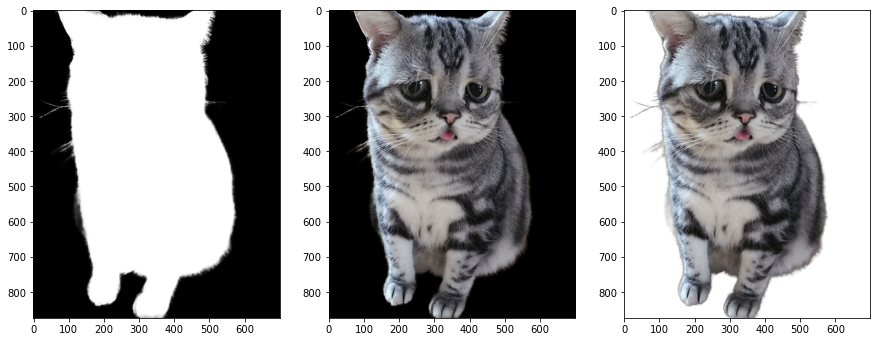

In [14]:
plt.figure(figsize=(15, 15))
plt.subplot(1,3,1)
plt.imshow(out, cmap='gray')
plt.subplot(1,3,2)
plt.imshow(rgb_out)
plt.subplot(1,3,3)
plt.imshow(transparent_out)

In [15]:
rgb_out_reverse = rgb_out[...,::-1]
rgb_result = "test_images/hinh-anh-meo-buon-ngo-nghinh_020436092_rgb_result.jpg"
result = "test_images/hinh-anh-meo-buon-ngo-nghinh_020436092_result.png"
transparent_result = "test_images/hinh-anh-meo-buon-ngo-nghinh_020436092_transparent_result.png"
cv.imwrite(rgb_result, rgb_out_reverse)
cv.imwrite(result, out)
cv.imwrite(transparent_result, np.concatenate([rgb_out_reverse, out_expand], axis=2))

True